#### CSC 180 Intelligent Systems 

#### William Lorence, Ajaydeep Singh, Romin Akoliya, Abdurraziq Paikur

#### California State University, Sacramento

# Final Project: NBA Outcome Predictions

NBA statistics can be very complex, so first, we will break down exactly what we are looking for.



In [ ]:
import pandas as pd
import numpy as np
from nba_api.stats.static import teams, players
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.endpoints import playercareerstats

player_name = "Stephen Curry"
player_info = players.find_players_by_full_name(player_name)

if player_info:
    player_id = player_info[0]['id']  # Get the ID of the first match
    print(f"Player ID for {player_name}: {player_id}")
else:
    print(f"No player found with the name {player_name}")

career = playercareerstats.PlayerCareerStats(player_id=player_id)
career_data = career.get_data_frames()[0]

print(career_data.columns)

Player ID for Stephen Curry: 201939
Index(['PLAYER_ID', 'SEASON_ID', 'LEAGUE_ID', 'TEAM_ID', 'TEAM_ABBREVIATION',
       'PLAYER_AGE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')


In [34]:
team_name = "Los Angeles Lakers"
opposing_team_name = "New Orleans Pelicans"

team_info = teams.find_teams_by_full_name(team_name)

if team_info:
    team_id = team_info[0]['id']  # Get the ID of the first match
    print(f"Team ID for {team_name}: {team_id}")
else:
    print(f"No team found with the name {team_name}")

opposing_team_info = teams.find_teams_by_full_name(opposing_team_name)

if opposing_team_info:
    opposing_team_id = opposing_team_info[0]['id']  # Get the ID of the first match
    print(f"Team ID for {opposing_team_name}: {opposing_team_id}")
else:
    print(f"No team found with the name {opposing_team_name}")

gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=team_id, vs_team_id_nullable=opposing_team_id)
team_games = gamefinder.get_data_frames()[0]  # Fetch the data as a DataFrame

# Filter for games from the last 20 years
team_games.rename(columns={'SEASON_ID': 'SEASON'}, inplace=True)
team_games['SEASON'] = team_games['SEASON'].str[1:5].astype(int)
team_games = team_games[team_games['SEASON'] >= 2020]

# Create a simple win/loss indicator
team_games['WL'] = team_games['WL'] == 'W'
team_games.rename(columns={'WL': 'WIN'}, inplace=True)

# Change "matchup" to "opponent"
team_games['MATCHUP'] = team_games['MATCHUP'].str[-3:]
team_games.rename(columns={'MATCHUP': 'OPPONENT'}, inplace=True)

# Drop unnecessary columns
team_games = team_games.drop(['TEAM_ID', 'GAME_ID', 'GAME_DATE', 'TEAM_NAME', 'MIN'], axis=1)

team_games

Team ID for Los Angeles Lakers: 1610612747
Team ID for New Orleans Pelicans: 1610612740


,SEASON,TEAM_ABBREVIATION,OPPONENT,WIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,2024,LAL,NOP,True,104,39,89,0.438,12,40,...,0.778,17,26,43,24,10,3,11,14,5.0
1,2023,LAL,NOP,True,110,35,84,0.417,14,35,...,0.897,6,35,41,24,8,7,8,12,4.0
2,2023,LAL,NOP,True,124,48,87,0.552,11,29,...,0.944,7,32,39,32,12,3,14,13,16.0
3,2023,LAL,NOP,True,139,49,88,0.557,14,31,...,0.844,5,27,32,32,5,5,7,20,17.0
4,2023,LAL,NOP,False,109,39,82,0.476,10,32,...,0.840,4,31,35,26,8,10,13,15,-20.0
5,2023,LAL,NOP,True,133,47,86,0.547,17,35,...,0.759,11,48,59,31,6,4,14,16,44.0
6,2022,LAL,NOP,True,123,40,82,0.488,18,39,...,0.893,15,37,52,24,8,2,17,16,15.0
7,2022,LAL,NOP,True,120,44,83,0.530,10,37,...,0.611,6,37,43,32,5,8,10,23,18.0
8,2022,LAL,NOP,False,126,45,94,0.479,11,32,...,0.758,13,31,44,30,4,3,9,20,-5.0
9,2022,LAL,NOP,True,120,45,98,0.459,10,36,...,0.870,11,45,56,30,6,8,17,17,3.0


## Initial Data Gathering

#### First, we pull the data from the NBA stats website using the NBA API. The desired outcome is to have datasets for each of the 30 NBA teams from the 2021 season onward.

SEASON_ID is modified to contain the year instead of the season ID; the two are closely linked and only a simple mutation is necessary. (22024 -> 2024)
WL is modified to become a boolean instead of containing W and L.
MATCHUP is modified to drop the team in question and only leave the opponent, as it contained redundant information. (BOS vs. LAL -> LAL)

#### Some data is removed from the table. Here is a list and reasons:

TEAM_ID, GAME_ID: Numbers only useful within the NBA API workflow, not for statistics
GAME_DATE: The date a game takes place is not very impactful in determining who wins
TEAM_NAME: Redundant, only need three letter team abbreviation
MIN: Length of the game, not relevant as most games (sparing overtime) are around the same length
PLUS_MINUS: Point differential between the team in question and the opponent; can provide redundant information as teams with a positive plus-minus are guaranteed to have won the game

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nba_api.stats.endpoints import leaguegamefinder

# Find all NBA regular season games from 2021 onward (NBA id = 00)

gamefinder = leaguegamefinder.LeagueGameFinder(league_id_nullable='00', season_type_nullable='Regular Season')
games = gamefinder.get_data_frames()[0]  # Fetch the data as a DataFrame

games.rename(columns={'SEASON_ID': 'SEASON'}, inplace=True)
games['SEASON'] = games['SEASON'].str[1:5].astype(int)
games = games[games['SEASON'] >= 2019]

# Create a simple win/loss indicator
games['WL'] = games['WL'] == 'W'
games = games.replace({True: 1, False: 0})
games.rename(columns={'WL': 'WIN'}, inplace=True)

# Change "matchup" to "opponent" and "team_abbreviation" to "team"
games['MATCHUP'] = games['MATCHUP'].str[-3:]
games.rename(columns={'MATCHUP': 'OPPONENT'}, inplace=True)
games.rename(columns={'TEAM_ABBREVIATION': 'TEAM'}, inplace=True)

# Drop unnecessary columns
games = games.drop(['TEAM_ID', 'GAME_ID', 'GAME_DATE', 'TEAM_NAME', 'MIN', 'PLUS_MINUS'], axis=1)

C:\Users\legow\AppData\Local\Temp\ipykernel_2304\4059632195.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  games = games.replace({True: 1, False: 0})


#### The following function simply normalizes the various game statistics on a league-wide scale. This is important, because it will show which teams average higher numbers.

In [92]:
def normalize_columns(df, columns = []):
    for col in columns:
        df[col] = (df[col] - df[col].mean()) / df[col].std()
    return df

games = normalize_columns(games, ['PTS', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF'])

games

,SEASON,TEAM,OPPONENT,WIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,...,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF
0,2024,ORL,LAL,1,0.498964,0.310993,0.355028,0.082326,0.632158,0.761267,...,-0.199190,0.780543,1.250345,-0.145303,0.591537,1.144376,0.156803,0.054250,0.694058,1.273609
1,2024,UTA,SAS,0,0.419305,-0.072089,1.352498,-0.917245,0.117702,1.488696,...,0.508840,1.058251,0.454416,0.588924,0.742395,-0.638708,-1.229930,0.860251,0.176664,2.227187
2,2024,LAL,ORL,0,0.419305,0.502534,-0.214955,0.682069,0.117702,-0.548106,...,0.508840,-1.232843,-0.341513,-1.246645,-1.218747,-0.836828,-1.229930,0.457251,-0.858125,-1.110337
3,2024,MIN,TOR,0,-0.616256,-1.604416,-1.212425,-1.008115,-0.139527,0.033838,...,1.500081,0.393735,-0.076203,-0.695974,-0.615319,-1.827431,1.543535,0.054250,0.952755,1.035214
4,2024,DET,CHA,0,0.658281,0.119452,1.494994,-0.808201,1.146614,1.925154,...,0.367234,0.215208,2.842203,0.221811,1.798394,0.946256,0.156803,-0.751751,1.470150,0.796820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12111,2019,CHA,CHI,1,1.056574,0.694075,-0.072459,0.772939,2.689983,1.343211,...,-0.907220,0.344144,-0.341513,-0.328860,-0.464462,0.550015,-1.576613,-0.348750,1.470150,-0.395153
12112,2019,LAL,LAC,0,-0.855232,-0.838252,-0.499946,-0.608287,0.117702,-0.257134,...,-0.199190,-0.637754,-0.341513,-0.328860,-0.464462,-1.034949,-1.229930,0.860251,0.176664,1.035214
12113,2019,TOR,NOP,1,1.375208,0.119452,2.064977,-1.098985,0.374930,0.761267,...,2.208111,0.631771,1.515655,1.323152,1.949251,-0.440587,-0.189880,-0.751751,0.694058,1.035214
12114,2019,NOP,TOR,0,0.737940,0.310993,1.922481,-0.844549,1.661071,1.488696,...,-0.340796,0.711116,1.515655,0.588924,1.345823,0.946256,-1.229930,1.666252,1.470150,3.419160


#### After normalization, we can finally split the data into the respective team files.

In [93]:
def create_team_csv_files(df, column = 'TEAM'):
    for team in df[column].unique():
        team_df = df.loc[df[column] == team]
        team_df.to_csv('datasets/' + team + '.csv', index=False)

create_team_csv_files(games)

#### With our csv files now created to refer to, we can read from them and feed the appropriate data to the model. However, some manipulation needs to be done first that would cause the size of the CSV files to be unnecessarily large.

In [94]:
team1 = "LAL"
df_team1 = pd.read_csv('datasets/' + team1 + '.csv')

df_team1

,SEASON,TEAM,OPPONENT,WIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,...,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF
0,2024,LAL,ORL,0,0.419305,0.502534,-0.214955,0.682069,0.117702,-0.548106,...,0.508840,-1.232843,-0.341513,-1.246645,-1.218747,-0.836828,-1.229930,0.457251,-0.858125,-1.110337
1,2024,LAL,UTA,1,0.897257,0.119452,-1.782408,1.536248,0.374930,-0.548106,...,1.924899,-0.558408,-1.137442,-1.063088,-1.520461,0.946256,0.503486,0.054250,0.176664,-0.871943
2,2024,LAL,NOP,1,-0.695914,-0.455170,0.070036,-0.553765,-0.139527,0.761267,...,-0.624008,-0.002991,1.780964,-1.430202,-0.162748,-0.242467,0.850169,-0.751751,-0.599427,-1.348732
3,2024,LAL,SAS,1,0.578623,0.502534,-0.072459,0.573025,0.374930,-0.548106,...,0.084022,0.046599,-0.076203,-0.512417,-0.464462,0.351894,0.850169,-0.751751,-0.858125,-2.063916
4,2024,LAL,MEM,1,1.215891,0.310993,-0.499946,0.682069,1.918299,0.906753,...,1.358475,-0.895626,-0.872132,0.221811,-0.313605,1.144376,-0.189880,0.054250,1.211452,0.558425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,2019,LAL,DAL,1,0.498964,1.077157,1.067507,0.391284,-0.911211,-0.402620,...,-0.199190,-0.161682,-1.137442,0.221811,-0.464462,-0.242467,1.196852,0.860251,-0.599427,0.320030
400,2019,LAL,MEM,1,0.578623,-0.263630,-0.357451,-0.063066,-1.425667,-1.275535,...,2.349717,0.671443,-0.076203,1.873823,1.496680,-0.044347,0.503486,1.263252,1.211452,-0.156759
401,2019,LAL,CHA,1,0.578623,1.460238,0.640019,1.063723,-0.396755,-0.548106,...,-1.190432,0.076354,-0.076203,0.588924,0.440680,0.946256,-0.189880,1.263252,-0.082033,0.558425
402,2019,LAL,UTA,1,-1.412842,-1.412875,-0.357451,-1.335247,-1.168439,-1.275535,...,0.225628,0.135863,0.189106,-0.512417,-0.313605,-1.233069,2.236901,1.666252,0.176664,0.320030


#### First, we one-hot encode the opponent column, as it is the only qualitative column we will be keeping. Then, we will remove the season and team columns because they are redundant, and only helped identify that the data is coming from the correct place.

In [95]:
df_team1 = pd.get_dummies(df_team1, columns=['OPPONENT'])

df_team1 = df_team1.drop(['SEASON','TEAM'],axis=1)
df_team1

,WIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,...,OPPONENT_OKC,OPPONENT_ORL,OPPONENT_PHI,OPPONENT_PHX,OPPONENT_POR,OPPONENT_SAC,OPPONENT_SAS,OPPONENT_TOR,OPPONENT_UTA,OPPONENT_WAS
0,0,0.419305,0.502534,-0.214955,0.682069,0.117702,-0.548106,0.702141,-0.074860,0.508840,...,False,True,False,False,False,False,False,False,False,False
1,1,0.897257,0.119452,-1.782408,1.536248,0.374930,-0.548106,1.094282,1.452652,1.924899,...,False,False,False,False,False,False,False,False,True,False
2,1,-0.695914,-0.455170,0.070036,-0.553765,-0.139527,0.761267,-0.711943,-0.584031,-0.624008,...,False,False,False,False,False,False,False,False,False,False
3,1,0.578623,0.502534,-0.072459,0.573025,0.374930,-0.548106,1.094282,0.094864,0.084022,...,False,False,False,False,False,False,True,False,False,False
4,1,1.215891,0.310993,-0.499946,0.682069,1.918299,0.906753,1.522072,0.773758,1.358475,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,1,0.498964,1.077157,1.067507,0.391284,-0.911211,-0.402620,-0.937721,-0.244583,-0.199190,...,False,False,False,False,False,False,False,False,False,False
400,1,0.578623,-0.263630,-0.357451,-0.063066,-1.425667,-1.275535,-1.080318,2.640717,2.349717,...,False,False,False,False,False,False,False,False,False,False
401,1,0.578623,1.460238,0.640019,1.063723,-0.396755,-0.548106,-0.058375,-1.093201,-1.190432,...,False,False,False,False,False,False,False,False,False,False
402,1,-1.412842,-1.412875,-0.357451,-1.335247,-1.168439,-1.275535,-0.616879,0.264587,0.225628,...,False,False,False,False,False,False,False,False,True,False


#### Finally, we can split the data into X and y, where y is the WIN column and X is the remainder of the data. The data is then split into training and test data.

In [96]:
from sklearn.model_selection import train_test_split

# Select features and target
X = df_team1.drop('WIN', axis=1)  # Use more features if available
y = df_team1['WIN']  # Target variable

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Display the shape of training and test sets
print("Training features shape:", X_train.shape)
print("Test features shape:", X_test.shape)

Training features shape: (282, 47)
Test features shape: (122, 47)


## Creating a Simple Model for Testing

In [97]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    Dense(32, activation='relu'),  # Hidden layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 64)             │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,185 (20.25 KB)

 Trainable params: 5,185 (20.25 KB)

 Non-trainable params: 0 (0.00 B)

#### Training the Model

In [98]:
from tensorflow.keras.callbacks import EarlyStopping

def train_model(model, X_train, y_train):
    # EarlyStopping to monitor validation loss
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,  # 20% of training data for validation
        epochs=50,             # Maximum number of epochs
        batch_size=32,         # Number of samples per gradient update
        callbacks=[early_stopping],
        verbose=1              # Display training progress
)
    
train_model(model, X_train, y_train)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5144 - loss: 0.7011 - val_accuracy: 0.6842 - val_loss: 0.6135
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5712 - loss: 0.6600 - val_accuracy: 0.7895 - val_loss: 0.5865
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6989 - loss: 0.6072 - val_accuracy: 0.8070 - val_loss: 0.5576
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7837 - loss: 0.5567 - val_accuracy: 0.8070 - val_loss: 0.5280
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7641 - loss: 0.5202 - val_accuracy: 0.8070 - val_loss: 0.4973
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7788 - loss: 0.4919 - val_accuracy: 0.8246 - val_loss: 0.4722
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8014 - loss: 0.4679 - val_accuracy: 0.8070 - val_loss: 0.4555
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8483 - loss: 0.4374 - val_accuracy: 0.8246 - val_loss: 0.4416
Epoch 9

#### Evaluating the Model

In [99]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, x_test, y_test):
    # Make predictions on the test set
    y_pred = model.predict(x_test)
    
    # Convert probabilities to binary predictions if your model outputs probabilities
    y_pred_classes = (y_pred > 0.5).astype(int)  # Use the appropriate threshold

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)

    # Print the confusion matrix
    print("Confusion Matrix:\n", cm)

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes)

    # Print the results
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    # Plot the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Get the probability predictions
    y_pred_prob = model.predict(x_test)

    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Compute AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Confusion Matrix:
 [[41  3]
 [14 64]]
Precision: 0.9552238805970149
Recall: 0.8205128205128205
F1-Score: 0.8827586206896552


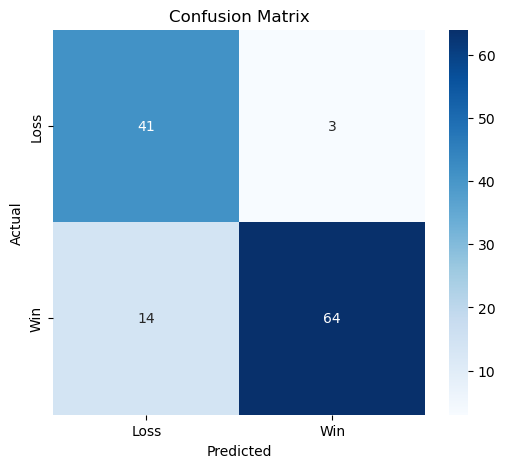

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step


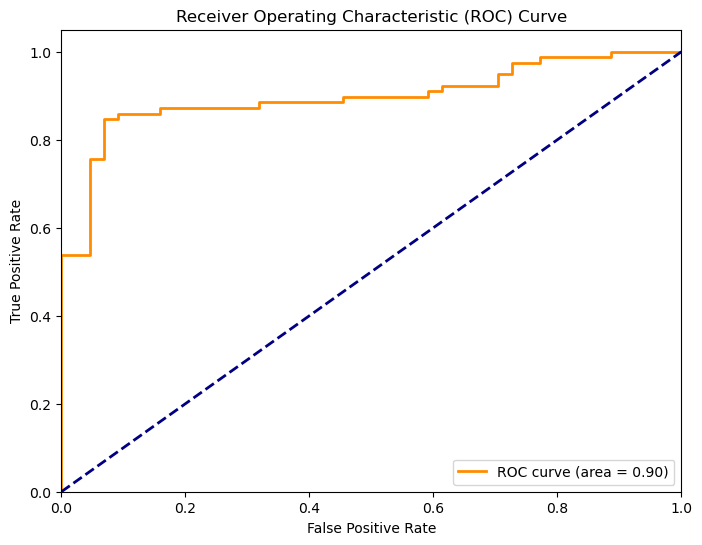

In [100]:
evaluate_model(model, X_test, y_test)

#### As we can see, the model is fairly accurate based on this data. However, we would also like to accomplish a few more things:

Test different kinds of models and model complexities

See raw probabilities (instead of rounding between 0 and 1) for betting odds - this is easy to do, as the model already outputs probabilities

Other possibilites, such as predicting season record (sum of predicted wins and losses for future schedule)




## Testing other Models

#### We will first be testing other types of models to see which is more accurate moving forward.

#### More complex FCNN Model

c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 256)            │        12,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,505 (209.00 KB)

 Trainable params: 53,505 (209.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6895 - loss: 0.5776 - val_accuracy: 0.8246 - val_loss: 0.3710
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8481 - loss: 0.4076 - val_accuracy: 0.8246 - val_loss: 0.3665
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8314 - loss: 0.3853 - val_accuracy: 0.8070 - val_loss: 0.3954
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8558 - loss: 0.3246 - val_accuracy: 0.8421 - val_loss: 0.3826
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8494 - loss: 0.3097 - val_accuracy: 0.8421 - val_loss: 0.3617
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8951 - loss: 0.2406 - val_accuracy: 0.8246 - val_loss: 0.3494
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9008 - loss: 0.2504 - val_accuracy: 0.8246 - val_loss: 0.3552
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8908 - loss: 0.2620 - val_accuracy: 0.7895 - val_loss: 0.3635
Epoch 9

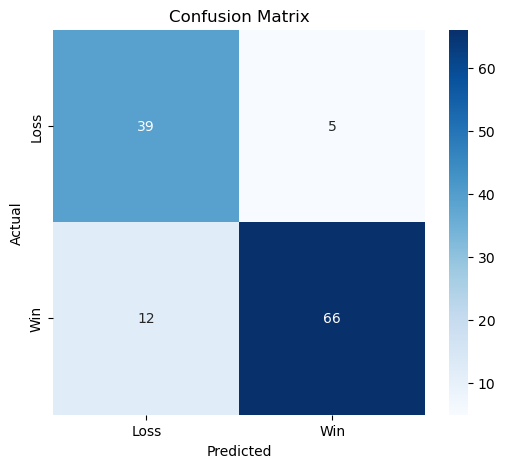

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step


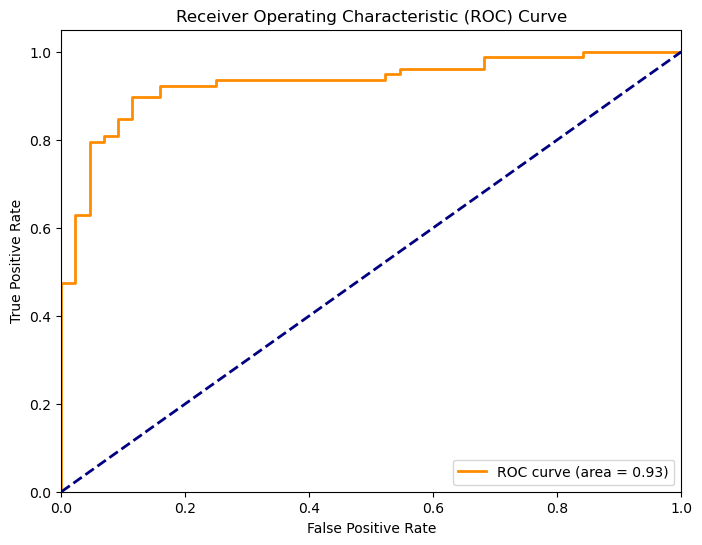

In [101]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Define the model
fcnn_model = Sequential([
    Dense(256, activation='tanh', input_shape=(X_train.shape[1],)),  # Input layer
    Dense(128, activation='tanh'),  # Hidden layer
    Dense(64, activation='tanh'),  # Hidden layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
fcnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
fcnn_model.summary()

#Train the model
train_model(fcnn_model, X_train, y_train)

#Evaluate the model
evaluate_model(fcnn_model, X_test, y_test)

#### CNN Model

c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_26 (Conv1D)              │ (None, 45, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 41, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 377,473 (1.44 MB)

 Trainable params: 377,473 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6491 - loss: 0.5945 - val_accuracy: 0.7719 - val_loss: 0.4844
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8154 - loss: 0.4190 - val_accuracy: 0.7895 - val_loss: 0.4377
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8375 - loss: 0.4130 - val_accuracy: 0.7193 - val_loss: 0.5313
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7723 - loss: 0.4528 - val_accuracy: 0.7544 - val_loss: 0.5220
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7649 - loss: 0.4660 - val_accuracy: 0.8246 - val_loss: 0.3923
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8543 - loss: 0.3724 - val_accuracy: 0.8421 - val_loss: 0.4041
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8818 - loss: 0.2924 - val_accuracy: 0.8070 - val_loss: 0.4475
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8701 - loss: 0.3182 - val_accuracy: 0.8070 - val_loss: 0.4376
Epoch 9

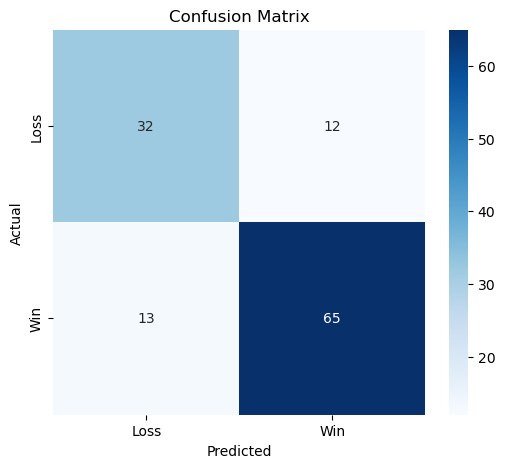

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


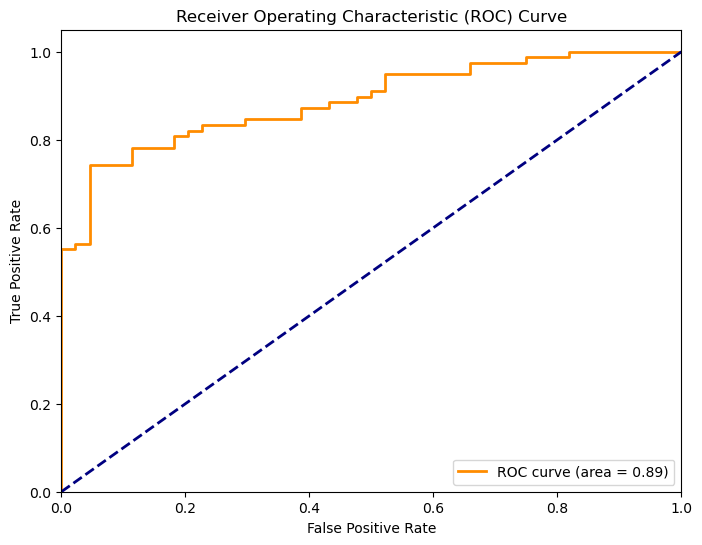

In [102]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten

def create_cnn(input_shape=(X_train.shape[1], 1), activation='tanh', neuron_count_array=[64,32], kernel_size_array=[3,3]):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=kernel_size_array[0], activation=activation, input_shape=(input_shape)))
    for i in range(len(kernel_size_array)-1):
        model.add(Conv1D(filters=128, kernel_size=kernel_size_array[i+1], activation=activation))
        model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    for j in range(len(neuron_count_array)-1):
        model.add(Dense(neuron_count_array[j], activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

# Create CNN Model
cnn_model = create_cnn((X_train.shape[1], 1), activation='tanh', neuron_count_array=[128,64,32], kernel_size_array=[3,5])

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
cnn_model.summary()

# Train the model
train_model(cnn_model, X_train, y_train)

# Evaluate the model
evaluate_model(cnn_model, X_test, y_test)